In [16]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 1) Preparando terreno

In [17]:
def image2array(nome_arquivo, startHeight = 0, startWidth = 0):
    """
    Converte uma imagem em um array NumPy normalizado (float32).

    Parameters
    ----------
    nome_arquivo : str
        O caminho para o arquivo de imagem.
    startHeight : int, optional
        A altura inicial para começar a leitura dos pixels (default é 0).
    startWidth : int, optional
        A largura inicial para começar a leitura dos pixels (default é 0).

    Returns
    -------
    np.ndarray
        Um array NumPy de forma (altura-startHeight, largura-startWidth, 3) contendo os valores normalizados (float32) dos pixels da imagem.
    """
    imagem = Image.open(nome_arquivo)
    largura, altura = imagem.size

    matriz_pixels = np.zeros((altura-startHeight, largura-startWidth, 3), dtype=np.float32)
    for y in range(startHeight, altura):
        for x in range(startWidth, largura):
            r, g, b = imagem.getpixel((x, y))
            matriz_pixels[y-startHeight, x-startWidth] = [r/255, g/255, b/255]
    return matriz_pixels

def array2image(matriz_pixels):
    """
    Converte um array NumPy em uma imagem e mostra a image.

    Parameters
    ----------
    array : np.ndarray
        Um array NumPy de forma (altura, largura, 3) contendo os valores dos pixels da imagem. Os valores devem estar no intervalo [0, 1].

    Returns
    -------
    None
    """
    altura, largura, _ = matriz_pixels.shape
    imagem = Image.new('RGB', (largura, altura))
    for y in range(altura):
        for x in range(largura):
            r, g, b = matriz_pixels[y, x]
            imagem.putpixel((x, y), (int(r*255), int(g*255), int(b*255)))
    # Display image using matplotlib
    imagem.show()

def flatIdx2pos(idx, width):
    return (idx//width, idx%width)

def pos2flatIdx(pos, width):
    return pos[0]*width + pos[1]

In [18]:
sH = 1009
sW = 1722
imarr = image2array('vangogh.jpg', startHeight=sH, startWidth=sW)
#array2image(imarr)

In [19]:
altura, largura = imarr.shape[0], imarr.shape[1]
W = largura
total_pixels = altura * largura
imarr_flat = imarr.reshape(total_pixels, 3)
print(f"{altura} x {largura} = {total_pixels} pixels")

# Save .npy file
np.save(f'vangogh{sH}x{1722}.npy', imarr_flat)

1000 x 1000 = 1000000 pixels


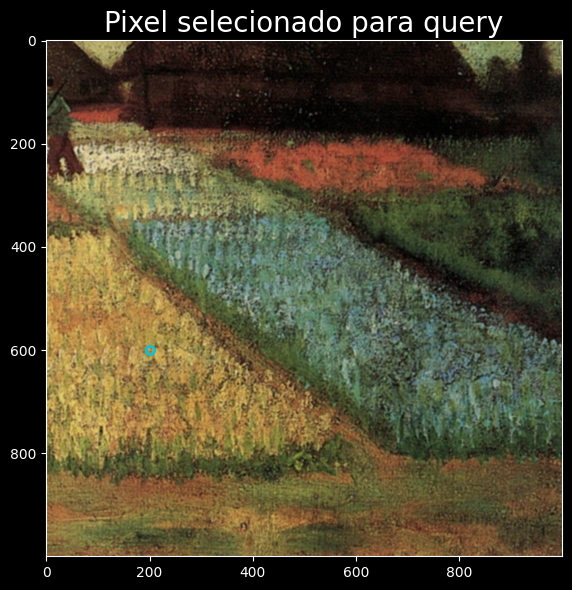

In [20]:
# Plot image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(imarr)
x = 200
y = 600
plt.plot(x, y, 'o', color='tab:cyan', mfc='none', mew=2)
plt.title('Pixel selecionado para query', fontsize=20)
plt.tight_layout()

In [47]:
def L2(query, features):
    # Compute L2 distance between query and features
    return np.sqrt(np.sum((query - features)**2, axis=1))

def knn(query, k, features, distFunc = None, tie = 0):
    """
    Realiza uma busca k-NN (k-Nearest Neighbors) utilizando uma função de distância personalizada.

    Parameters
    ----------
    query : np.ndarray
        O vetor de consulta para o qual os vizinhos mais próximos serão encontrados.
    k : int
        O número de vizinhos mais próximos a serem retornados.
    features : np.ndarray
        Um array 2D onde cada linha é um vetor de características.
    distFunc : callable, optional
        A função de distância a ser utilizada. Se None, a função L2 (distância Euclidiana) será utilizada (default é None).
    tie : int, optional
        Se 1, verifica se há mais características com a mesma distância que o k-ésimo vizinho mais próximo e as inclui no resultado (default é 0).

    Returns
    -------
    list of tuple
        Uma lista de tuplas onde cada tupla contém o índice e a distância do vizinho mais próximo no array de características.
        A lista é ordenada pela distância em ordem crescente.

    Notes
    -----
    Em caso de empate (distâncias iguais) e se `tie` for 1, todos os vizinhos com a mesma distância que o k-ésimo vizinho mais próximo são incluídos no resultado.
    """
    if distFunc is None:
        distFunc = L2
    
    distances = distFunc(query, features)
    k_nearest = []
    for i in range(k):
        min_idx = np.argmin(distances)
        k_nearest.append((min_idx, distances[min_idx]))
        distances[min_idx] = np.inf
        
    # Check if there are more features with the same distance
    if tie:
        min_idx = np.argmin(distances)
        while distances[min_idx] == k_nearest[-1][1]:
            k_nearest.append((min_idx, distances[min_idx]))
            distances[min_idx] = np.inf
            min_idx = np.argmin(distances)
    
    return k_nearest

In [22]:
query = imarr_flat[pos2flatIdx((y, x), W)]
features = np.load(f'vangogh{sH}x{sW}.npy')
k = 32
k_nearest = knn(query, k, features, tie=1)
print(k_nearest)

[(421104, 0.0), (425096, 0.0), (600200, 0.0), (690082, 0.0), (789059, 0.0), (436101, 0.0039215684), (443043, 0.0039215684), (720114, 0.0039215684), (464134, 0.005545935), (475025, 0.005545935), (692089, 0.005545935), (775032, 0.005545935), (779364, 0.005545935), (787058, 0.005545935), (396081, 0.006792356), (456150, 0.006792356), (465134, 0.006792356), (599198, 0.006792356), (600201, 0.006792356), (698055, 0.006792356), (701421, 0.006792356), (747012, 0.006792356), (803032, 0.006792356), (424098, 0.007843137), (453150, 0.007843137), (770359, 0.007843137), (339147, 0.008768894), (400086, 0.008768894), (401086, 0.008768894), (401118, 0.008768894), (408102, 0.008768894), (466106, 0.008768894)]


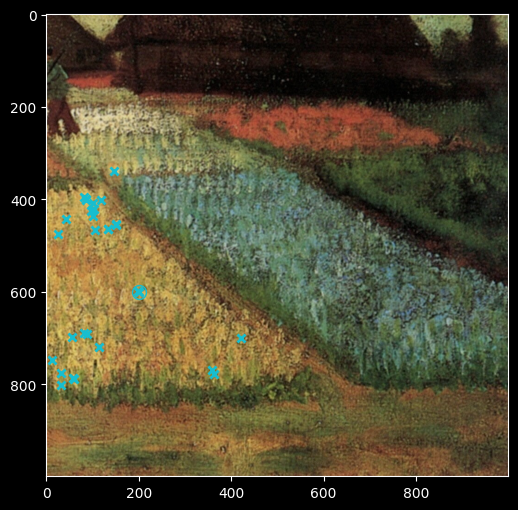

In [23]:
# Plot result in matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(imarr)
plt.plot(x, y, 'o', color='tab:cyan', mfc='none', mew=1, ms=10)
for i in range(len(k_nearest)):
    pos = flatIdx2pos(k_nearest[i][0], W)
    plt.plot(pos[1], pos[0], 'x', color='tab:cyan', mfc='none', mew=2)

# 2) Realizando N queries

In [58]:
sH = 0
sW = 0
imarr = image2array('vangogh.jpg', startHeight=sH, startWidth=sW)

H, W = imarr.shape[0], imarr.shape[1]
total_pixels = H * W
imarr_flat = imarr.reshape(total_pixels, 3)
print(f"{H} x {W} = {total_pixels} pixels")

# Save .npy file
np.save(f'vangogh{sH}x{sW}.npy', imarr_flat)

2009 x 2722 = 5468498 pixels


In [60]:
# Generate random list of queries in the form of coordinates (x, y)
m = 5
n = 5
N = m*n
list_of_queries = np.random.randint(0, total_pixels, N)

imarr_flat = np.load(f'vangogh{sH}x{sW}.npy')

In [61]:
# Calculate time for each query
import time
k = 64

# Perform k-NN search for each query
results = []
times = []
for query in list_of_queries:
    
    t0 = time.time()
    k_nearest = knn(imarr_flat[query], k, imarr_flat, tie=0)
    results.append(k_nearest)
    t1 = time.time()
    
    dt = (t1-t0)*100
    # Reset line
    print('\r', end='')
    print(f"Query {len(results)}: {dt:.3f} ms")
    times.append(dt)

# Mean and standard deviation of time
mean_time = np.mean(times)
std_time = np.std(times)
print(f"Mean time: {mean_time:.3f} \u00B1 {std_time:.3f} ms")

Query 1: 50.691 ms
Query 2: 43.588 ms
Query 3: 51.832 ms
Query 4: 55.229 ms
Query 5: 43.615 ms
Query 6: 44.079 ms
Query 7: 44.852 ms
Query 8: 43.169 ms
Query 9: 55.877 ms
Query 10: 55.043 ms
Query 11: 54.743 ms
Query 12: 43.952 ms
Query 13: 45.057 ms
Query 14: 46.530 ms
Query 15: 43.372 ms
Query 16: 42.990 ms
Query 17: 56.650 ms
Query 18: 51.754 ms
Query 19: 45.416 ms
Query 20: 43.530 ms
Query 21: 45.624 ms
Query 22: 61.044 ms
Query 23: 43.931 ms
Query 24: 45.162 ms
Query 25: 45.955 ms
Mean time: 48.147 ± 5.337 ms


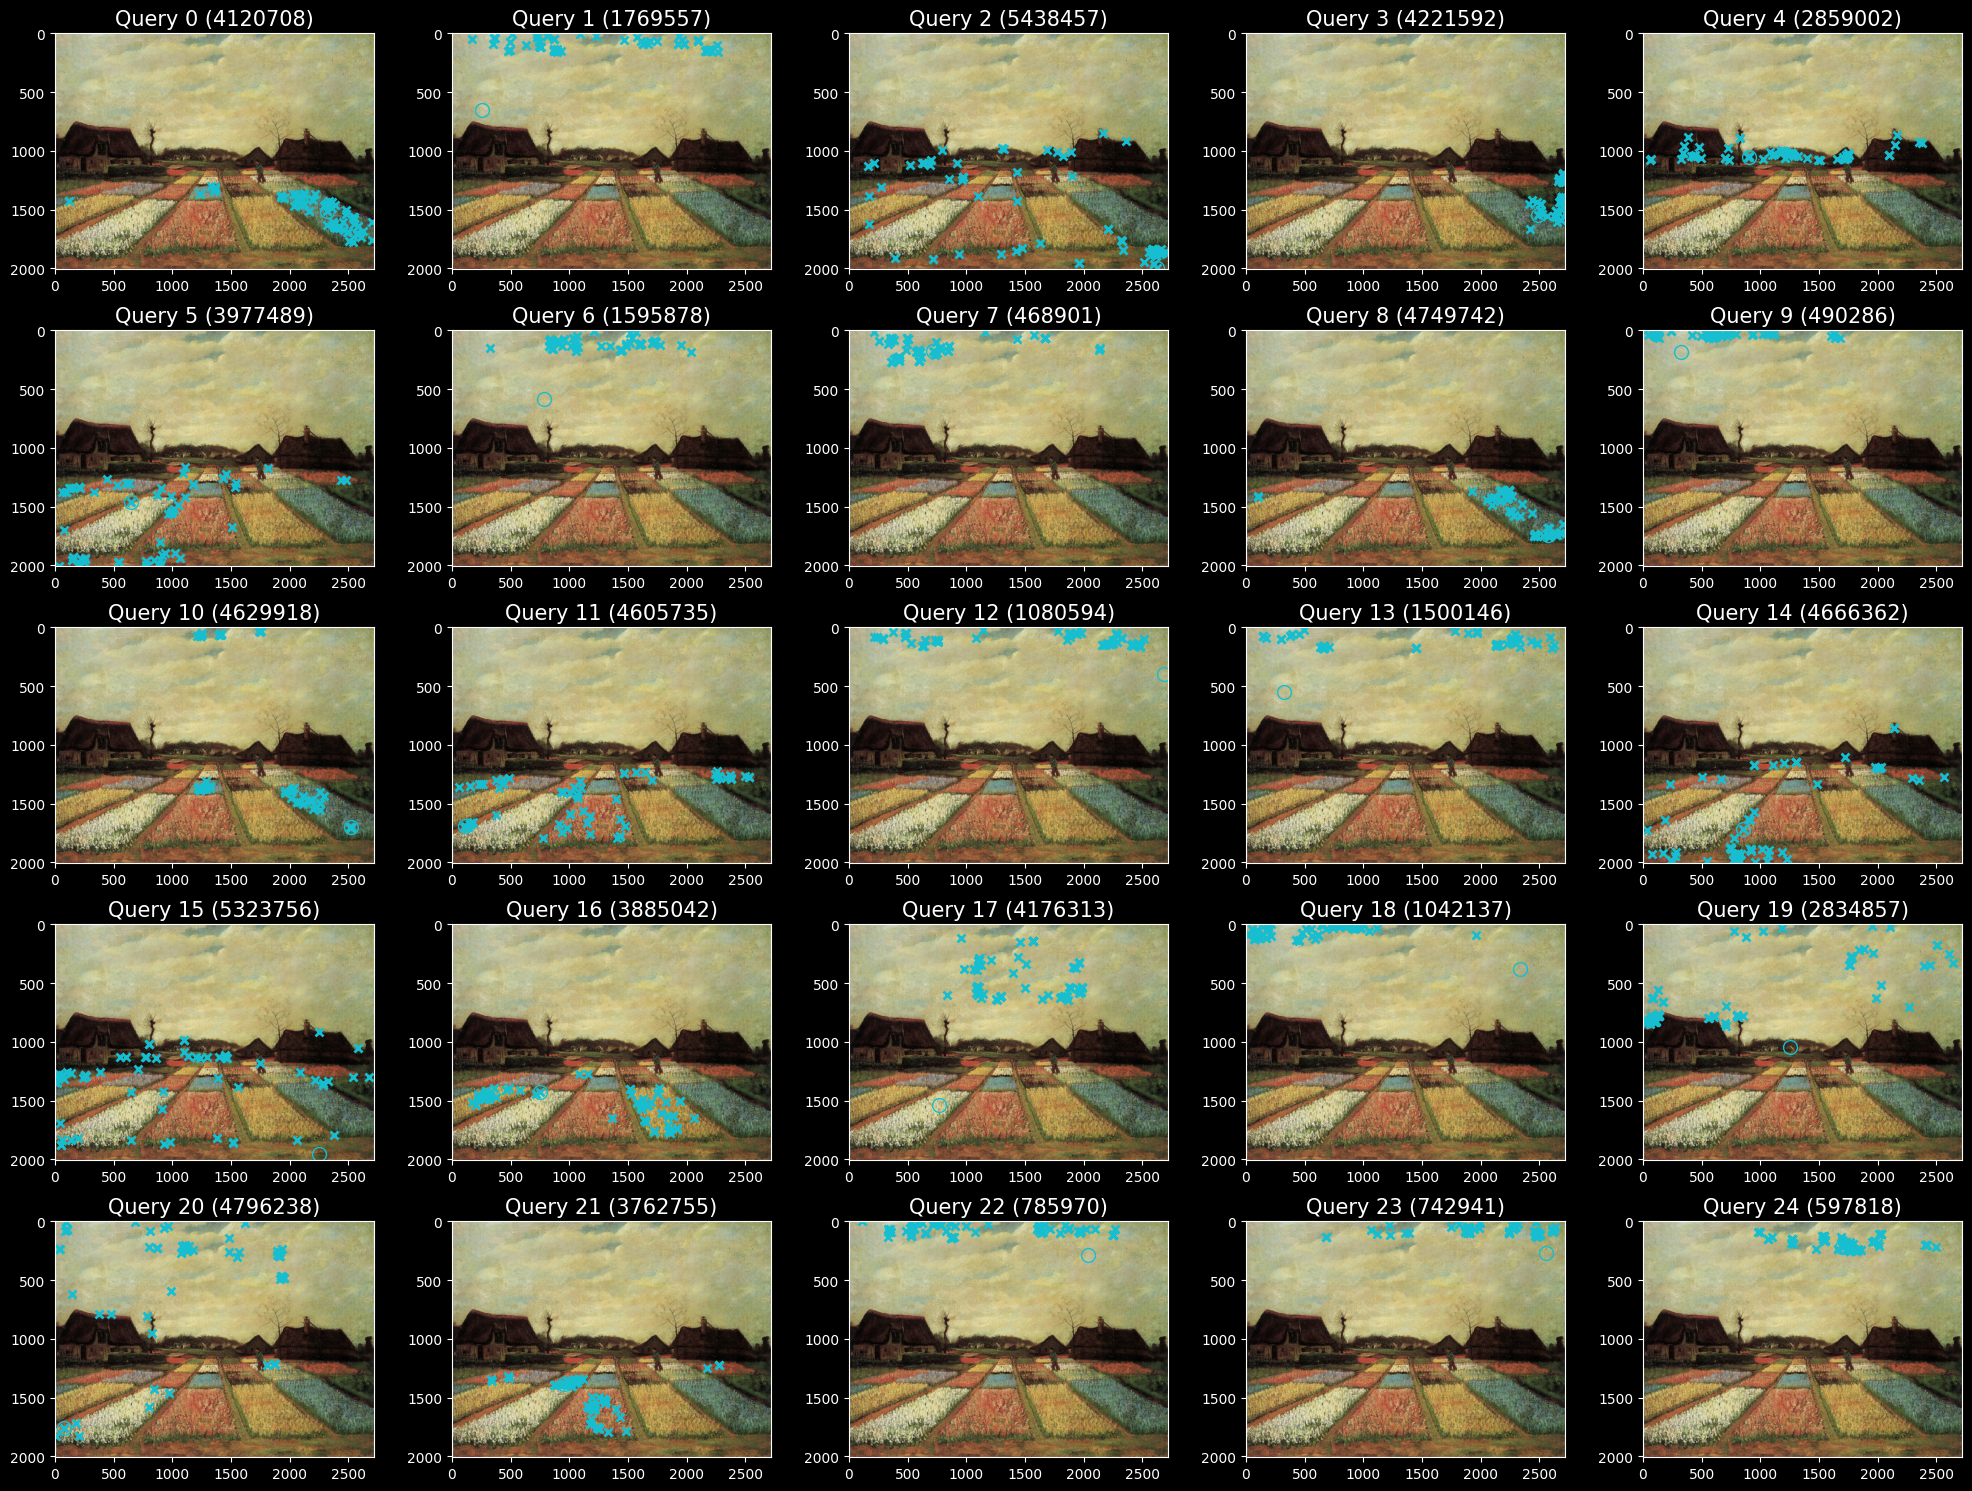

In [62]:
# Sample random results and plot it in grid (mxn)

plt.figure(figsize=(m*4, n*3))
for i in range(m*n):
    plt.subplot(m, n, i+1)
    plt.imshow(imarr)
    
    # Generate random query
    q = list_of_queries[i]
    plt.plot(flatIdx2pos(q, W)[1], flatIdx2pos(q, W)[0], 'o', color='tab:cyan', mfc='none', mew=1, ms=10)
    for j in range(len(results[i])):
        result = results[i][j]
        pos = flatIdx2pos(result[0], W)
        plt.plot(pos[1], pos[0], 'x', color='tab:cyan', mfc='none', mew=2)
    plt.title(f'Query {i} ({q})', fontsize=15)
plt.tight_layout()        